# Multi-Agent Reinforcement Learning for CORASAT

This notebook trains a shared-policy DQN baseline that controls the CORASAT drones without using a language model. The environment mirrors the inputs and action space from `run_simulation.ipynb`, allowing the trained agents to be compared directly against the language-model-driven strategy.

In [16]:
# Ensure repository root is importable before pulling in MARL modules
from pathlib import Path
import sys

def find_repo_root(start: Path) -> Path:
    start = start.resolve()
    candidates = [start] + list(start.parents)
    for candidate in candidates:
        if (candidate / 'Code' / 'corasat' / 'config.json').exists():
            return candidate
        if (candidate / 'config.json').exists():
            return candidate
    return start

repo_root = find_repo_root(Path.cwd())
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))

from marl_env import CorasatMultiAgentEnv, ACTION_NAMES
from marl_training import train_marl, evaluate_policy

print('Working directory:', Path.cwd())
print('Repository root:', repo_root)
print('Available actions:', ACTION_NAMES)


Working directory: c:\Users\Calvin\Calvin Drive\Calvin\Studium\Master Thesis\Code\corasat
Repository root: C:\Users\Calvin\Calvin Drive\Calvin\Studium\Master Thesis\Code\corasat
Available actions: ('wait', 'broadcast', 'move:north', 'move:south', 'move:east', 'move:west', 'move:northeast', 'move:northwest', 'move:southeast', 'move:southwest')


In [17]:
# Configure training hyperparameters for the shared MARL agent
# Training configuration (feel free to adjust)
training_config = {
    'num_episodes': 1024*4,
    'batch_size': 256*4,
    'buffer_capacity': 150000,
    'learning_rate': 0.0005,
    'gamma': 0.99,
    'epsilon_start': 1.0,
    'epsilon_end': 0.02,
    'epsilon_decay': None,
    'warmup_steps': 2000,
    'target_sync_interval': 0,
    'n_step': 3,
    'soft_tau': 0.01,
    'dueling': True,
    'hidden_dims': (512, 256),
    'replay_alpha': 0.6,
    'replay_beta_start': 0.4,
    'replay_beta_end': 1.0,
    'replay_beta_frames': 300000,
    'min_priority': 1e-05,
    'reward_overrides': {
        'step_penalty': -0.005,
        'wait_penalty': -0.02,
        'broadcast_penalty': -0.02,
        'new_tile_bonus': 0.18,
        'info_discovery_bonus': 0.12,
        'possible_target_bonus': 0.15,
        'intel_share_bonus': 0.1,
    },
    'eval_interval': 25,
    'eval_episodes': 4,
    'score_threshold': None,
    'record_playbacks_every': 25,
    'parallel_envs': 360000,
    'seed': 42,
}

epsilon_decay_target = (training_config['epsilon_end'] / training_config['epsilon_start']) ** (1.0 / max(1, training_config['num_episodes']))
training_config['epsilon_decay'] = epsilon_decay_target
print(f"Calibrated epsilon_decay: {training_config['epsilon_decay']:.6f}")

env = CorasatMultiAgentEnv(reward_config=training_config.get('reward_overrides'))
env.reset(seed=training_config.get('seed'))
print(f'Observation size: {env.observation_size}')
print(f'Number of drones: {len(env.agent_ids)}')
print(f'Max rounds per episode: {env.max_rounds}')


Calibrated epsilon_decay: 0.999045
Observation size: 249
Number of drones: 2
Max rounds per episode: 32


In [18]:
# Launch training and collect history for later analysis
from inspect import signature

sig = signature(train_marl)
allowed_keys = set(sig.parameters.keys())
call_kwargs = {k: v for k, v in training_config.items() if k in allowed_keys}
excluded_keys = sorted(set(training_config.keys()) - set(call_kwargs.keys()))
if excluded_keys:
    print('Ignoring unsupported training_config keys:', excluded_keys)

agent, training_history = train_marl(env, **call_kwargs)
print(f'Training complete: {len(training_history)} episodes')

try:
    import pandas as pd
except ImportError:
    pd = None

if pd is not None:
    history_records = []
    for entry in training_history:
        record = {
            'episode': entry.episode,
            'epsilon': entry.epsilon,
            'score': entry.score,
            'correct_edges': entry.correct_edges,
            'false_edges': entry.false_edges,
            'reported_edges': entry.reported_edges,
            'loss': entry.loss,
        }
        for agent_id, reward in entry.total_reward.items():
            record[f'reward_agent_{agent_id}'] = reward
        history_records.append(record)
    training_summary = pd.DataFrame(history_records)
    display(training_summary.tail())
else:
    for entry in training_history[-5:]:
        print(entry)

Training complete: 4096 episodes


,episode,epsilon,score,correct_edges,false_edges,reported_edges,loss,reward_agent_1,reward_agent_2
4091,4092,0.020077,5.0,5,0,5,1.222723e+09,5.90,2.78
4092,4093,0.020057,30.0,30,0,30,1.222843e+09,23.52,12.48
4093,4094,0.020038,28.0,28,0,28,1.222959e+09,17.44,18.44
4094,4095,0.020019,23.0,23,0,23,1.223024e+09,7.72,20.44
4095,4096,0.020000,25.0,25,0,25,1.223138e+09,15.08,13.28


In [19]:
eval_env = CorasatMultiAgentEnv()
evaluation = evaluate_policy(eval_env, agent, episodes=20, epsilon=0.0, seed=123)
print('Evaluation episodes:', evaluation.episodes)
print('Average score:', evaluation.average_score)
print('Average correct edges:', evaluation.average_correct_edges)
print('Average false edges:', evaluation.average_false_edges)
print('Average per-agent reward:', evaluation.average_reward)
print('Ground-truth edges:', eval_env.get_score_summary()['gt_edges'])

Evaluation episodes: 20
Average score: 3.85
Average correct edges: 3.85
Average false edges: 0.0
Average per-agent reward: {1: -5.030499999999999, 2: -6.080499999999999}
Ground-truth edges: 61


### Comparing against the language-model simulation

1. Run `run_simulation.ipynb` or `run_simulation.py` with the desired language model. Capture the final edge summary (score, correct, and false edges).
2. Use the evaluation statistics above to compare how the trained MARL policy performs relative to the language model. Both systems operate on the same board configuration, action space, and scoring function.
3. If you need side-by-side metrics, consider exporting the `training_summary` dataframe (if pandas is installed) and the logs from the LLM run, then analyse them in a separate notebook or script.

pygame 2.6.1 (SDL 2.28.4, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


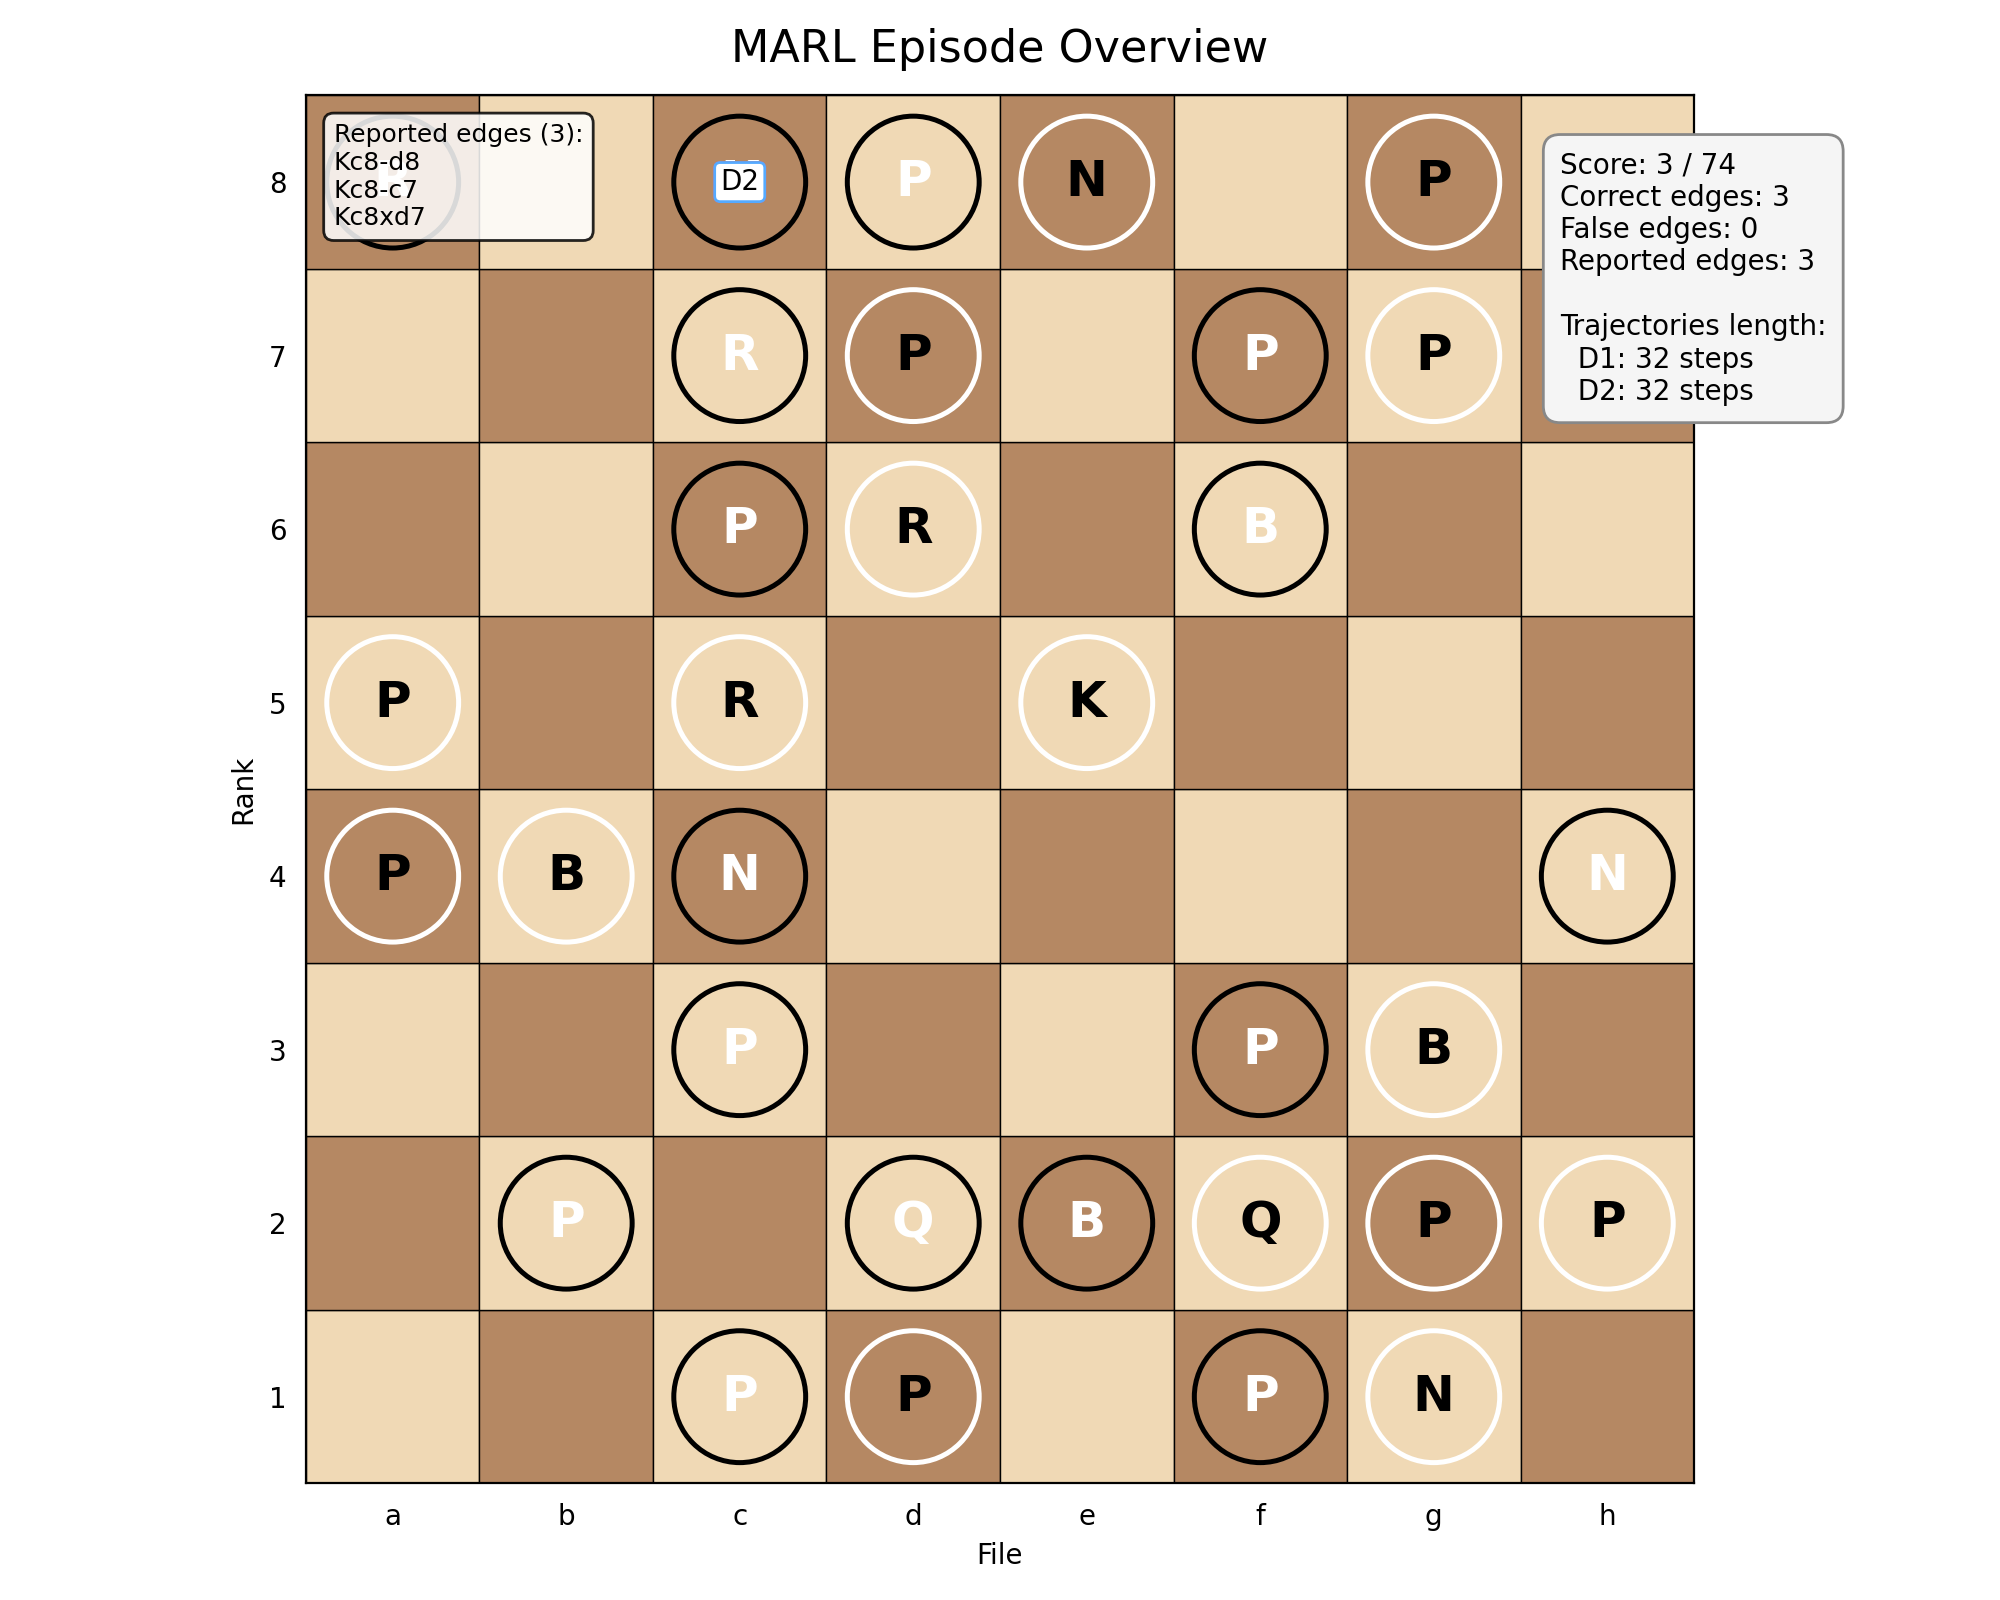

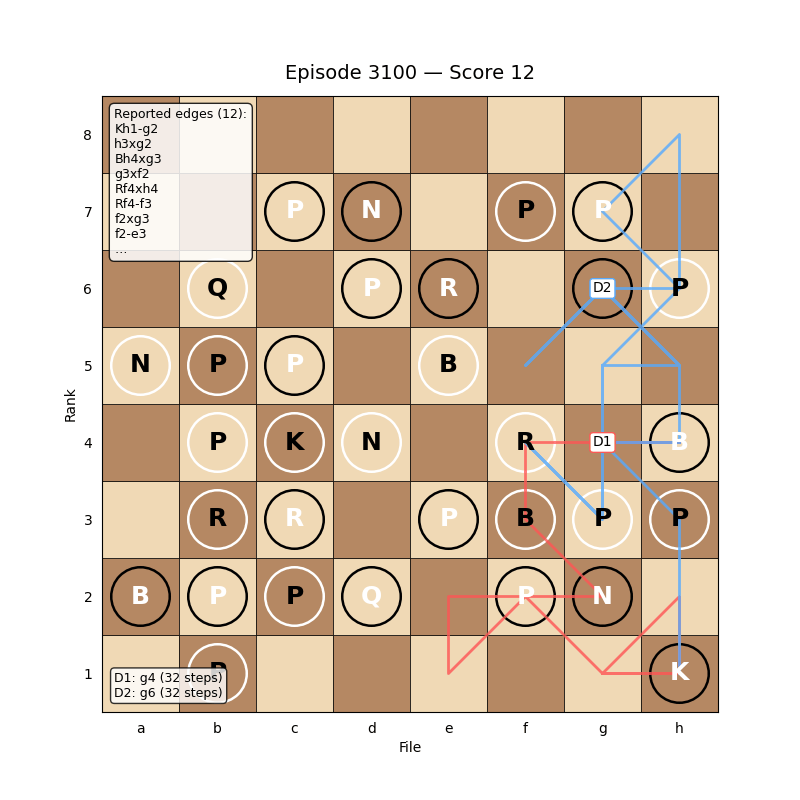

In [20]:
import importlib

marl_training = importlib.import_module('marl_training')
marl_training = importlib.reload(marl_training)

marl_visualization = importlib.import_module('marl_visualization')
marl_visualization = importlib.reload(marl_visualization)

best_episode = marl_training.play_episode(env, agent, epsilon=0.0, seed=training_config.get('seed'))
image_path = marl_visualization.render_episode_snapshot(
    best_episode, output_path='screenshots/marl_best_episode.png'
)

progress_path = None
try:
    progress_path = marl_visualization.render_training_progress_video(
        training_history,
        output_path='screenshots/marl_training_progress.gif',
        fps=6.0,
        max_episodes=40,
        episode_stride=1,
    )
except Exception as exc:
    print(f'Failed to generate training progress animation: {exc}')

try:
    from IPython.display import Image, display
    display(Image(filename=image_path))
    if progress_path:
        display(Image(filename=progress_path))
except Exception:
    print(f'Visualization saved to: {image_path}')
    if progress_path:
        print(f'Training progress GIF saved to: {progress_path}')


In [21]:
# Optional: save the trained agent to disk for later reuse
from pathlib import Path

checkpoint_path = Path('checkpoints/marl_dqn_agent.pt')
checkpoint_path.parent.mkdir(parents=True, exist_ok=True)
agent.save(str(checkpoint_path))
print(f'Checkpoint stored at: {checkpoint_path}')

Checkpoint stored at: checkpoints\marl_dqn_agent.pt


In [22]:
import torch
torch.cuda.is_available()

True